# Showing how images works in a computer

In [1]:
path = "/Users/gabilio/Documents/COURSERA/computer_vision_ibm/week2/baboon.png"

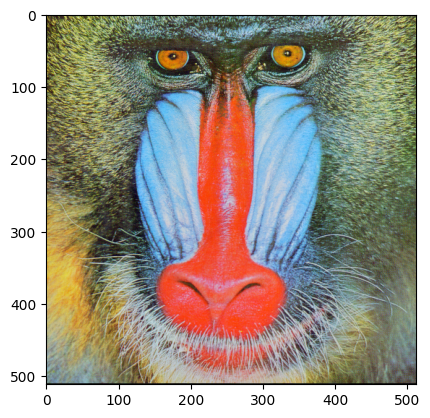

In [2]:
import imageio
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

im = imageio.imread(path)
plt.imshow(im)

In [3]:
im.shape

(512, 512, 3)

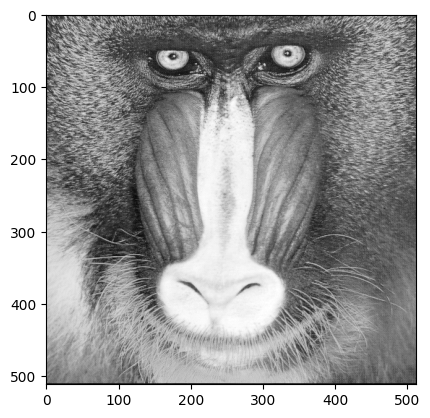

In [4]:
# Red channel:
plt.imshow(im[:, :, 0], cmap = "gray")

(512, 512)

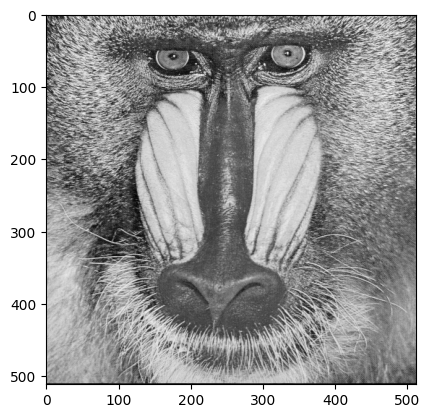

In [5]:
# Green channel:
plt.imshow(im[:, :, 1], cmap = "gray")
im[:, :, 1].shape

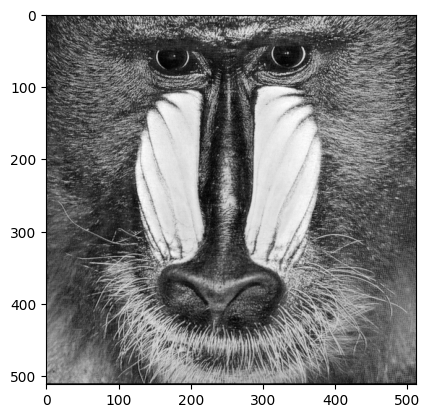

In [6]:
# Blue channel:
plt.imshow(im[:, :, 2], cmap = "gray")

# CNN

In [7]:
import numpy as np
import torch
import torch.nn.functional as F

Remembering how fully connected layers works:

In [8]:
# random flat input vector
x_fc = torch.randn(100, 784)

# weight matrix variable
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# bias variable
b = torch.zeros(10, requires_grad=True)

# fully connected layer
y_preact = torch.matmul(x_fc, W) + b
y = F.relu(y_preact)

# input/output shape
print(x_fc.shape)
print(y.shape)

torch.Size([100, 784])
torch.Size([100, 10])


### Convolutional layer

Convolution operator:

In [9]:
# random input
x_cnn = torch.randn(100, 1, 28, 28)

# convolutional kernel variable
W1 = torch.randn(16, 1, 3, 3)/np.sqrt(1*3*3)
W1.requires_grad_()

# bias variable
b1 = torch.zeros(16, requires_grad=True)

# convolutional layer
conv1_p = F.conv2d(x_cnn, W1, bias = b1, stride = 1, padding = 1)
conv1 = F.relu(conv1_p)

# input/output shape
print(x_cnn.shape)
print(conv1.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100, 16, 28, 28])


In [10]:
# 2nd layer variables
W2 = torch.randn(32, 16, 3, 3)/np.sqrt(16*3*3)
W2.requires_grad_()
b2 = torch.zeros(32, requires_grad=True)

# applying
conv2_p = F.conv2d(conv1, W2, bias = b2, stride = 1, padding = 1)
conv2 = F.relu(conv2_p)

# output shape
print(conv2.shape)

torch.Size([100, 32, 28, 28])


Reshaping:

In [11]:
M = torch.zeros(4,3)

M2 = M.view(1, 1, 12)
M3 = M.view(2, 1, 2, 3)
M4 = M.view(-1, 2, 3)
M5 = M.view(-1) 

# PS = -1 is used to infer the missing dim

In [12]:
x_reshape = x_fc.view(-1, 1, 28, 28)
x_reshape.shape

torch.Size([100, 1, 28, 28])

#### Pooling:

In [13]:
# using conv2:

# max pool
max_pool2 = F.max_pool2d(conv2, kernel_size = 2)

#average pool
avg_pool2 = F.avg_pool2d(conv2, kernel_size = 2)

print(max_pool2.shape)
print(avg_pool2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])


In [14]:
# confirm that the pooling is working:

# Recreate values in pooling figure and make it 4D
feature_map_fig = torch.tensor(np.array([[1,1,2,4],
                                        [5,6,7,8],
                                        [3,2,1,0],
                                        [1,2,3,4]], dtype=np.float32))
fmap_fig = feature_map_fig.view(1,1,4,4)

# max pool
max_pool_fig = F.max_pool2d(fmap_fig, kernel_size = 2)

# avg pool
avg_pool_fig = F.avg_pool2d(fmap_fig, kernel_size = 2)

print(max_pool_fig)
print(avg_pool_fig)

tensor([[[[6., 8.],
          [3., 4.]]]])
tensor([[[[3.2500, 5.2500],
          [2.0000, 2.0000]]]])


#### Striding:

In [15]:
# using conv1:
print(conv1.shape)

# applying 2nd layer with stride = 2
conv2_stride_2 = F.relu(F.conv2d(conv1, W2, bias = b2, stride = 2, padding = 1 ))

# shape of conv2 with/withou striding
print(conv2_stride_2.shape)
print(conv2.shape)

torch.Size([100, 16, 28, 28])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 28, 28])


### Model


In [16]:
import torch.nn as nn

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        # fc layer 1
        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = F.relu(x)
        
        # fc layer 2
        x = self.fc2(x)
        return x        

In [17]:
model = MNIST_CNN()
print(model)

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model  
model = MNIST_CNN()  # <---- change here

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # <---- change here

# Iterate through train set minibatchs 
for epoch in trange(3):  # <---- change here
    for images, labels in tqdm(train_loader):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = images  # <---- change here 
        y = model(x)
        loss = criterion(y, labels)
        # Backward pass
        loss.backward()
        optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images  # <---- change here 
        y = model(x)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}'.format(correct/total))

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 11116021.81it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 18815733.74it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 5471779.38it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 3324699.61it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9908999800682068
